In [1]:
import os
os.chdir("../")
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os.path as osp
from PIL import Image
import shutil
import cv2
from tqdm import tqdm

from tools.centernet_utils import centernet_det_decode, centernet_det_post_process
from tools.scopehead_utils import scopehead_det_decode
from src.factory.config_factory import cfg, show_configs, build_output
from tools.logger import setup_logger
from src.factory.graph_factory import GraphFactory
logger = setup_logger("./external/")

def to_pil(cv_img):
    img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
    return Image.fromarray(img)

In [2]:
cfg.merge_from_file("/home/acer/Documents/deep-learning-works/configs/shufflenetv2_csp.yml")
cfg.APEX = False
cfg.DISTRIBUTED = False
cfg.IO = False
cfg.RESUME = "/media/acer/5f45949f-0fc7-4475-965b-e61989afcc10/Downloads/model_101_0.3312.pth"

In [3]:
graph = GraphFactory.produce(cfg)
graph.load(cfg.RESUME)

2020-06-08 08:40:56,481 16474 base_graph.py INFO: Model Loaded Successfully


In [9]:
img_path = "/home/acer/Pictures/pedestrian7.jpg"
img = Image.open(img_path)
feat = graph.inference(img)[(128,128)]

In [10]:
hm = feat['hm'].cpu().numpy()
np.where(hm>0)

(array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([  0,   0,   0, ..., 119, 119, 119]),
 array([  0,   2,   3, ..., 205, 206, 207]))

In [11]:
w, h = img.size
c = np.array([[w / 2., h / 2.]], dtype=np.float32)
s = np.array([max(h, w) * 1.0])
dets = centernet_det_decode(feat['hm'].sigmoid_(), feat['wh'], reg=feat['reg'], K=100)
dets = dets.detach().cpu().numpy().reshape(1, -1, dets.shape[1])
dets_out = centernet_det_post_process(
    dets.copy(), 
    c, 
    s, 
    feat['hm'].shape[2], 
    feat['hm'].shape[3], 
    feat['hm'].shape[1]
)


In [20]:
from torchvision.ops import nms
dets = torch.Tensor(dets_out[0][1])

In [31]:
dets = torch.Tensor(dets_out[0][1])
keep_ids = nms(dets[:,:4], dets[:,4], 0.4)

In [37]:
dets_out[0][c]

[[637.907958984375,
  149.04681396484375,
  747.93359375,
  421.7083435058594,
  1.0473968982696533],
 [191.5950927734375,
  153.54603576660156,
  292.31280517578125,
  400.7878112792969,
  0.9870114922523499],
 [189.46009826660156,
  154.68746948242188,
  294.25030517578125,
  415.2133483886719,
  0.9824858903884888],
 [745.5357666015625,
  157.4832763671875,
  815.9801025390625,
  334.66937255859375,
  0.9270743131637573],
 [554.5426635742188,
  148.92909240722656,
  639.0856323242188,
  357.0520935058594,
  0.8807887434959412],
 [0.24847809970378876,
  146.5422821044922,
  36.235530853271484,
  344.01953125,
  0.8589878082275391],
 [0.6309450268745422,
  144.68698120117188,
  43.428672790527344,
  361.0068664550781,
  0.8408206701278687],
 [265.80364990234375,
  121.75910949707031,
  385.8138122558594,
  416.68011474609375,
  0.7784512042999268],
 [1.1507039070129395,
  146.77590942382812,
  35.44049835205078,
  327.5775451660156,
  0.7708946466445923],
 [264.6880187988281,
  126.89

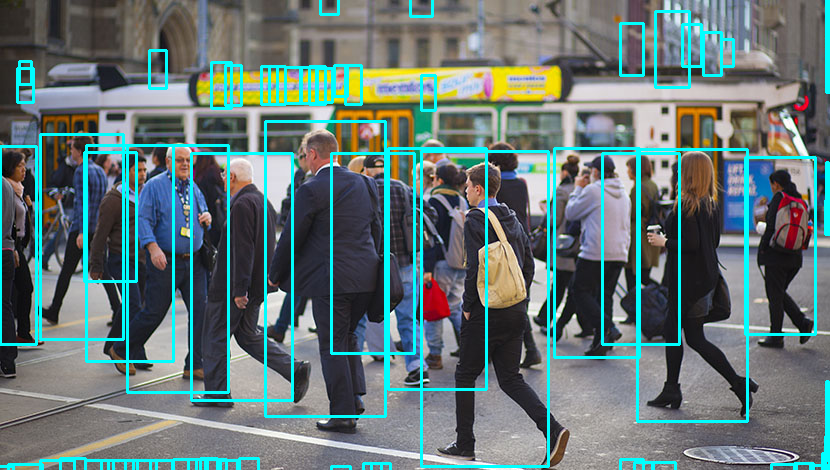

In [36]:
np_img = cv2.imread(img_path)
np_img = cv2.resize(np_img, (w, h))
num = 0
for c in dets_out[0]:
    for keep in keep_ids:
        x1, y1, x2, y2, score = dets_out[0][c][keep]
        if score > 0.9:
            num += 1
        cv2.rectangle(np_img, (int(x1), int(y1)), (int(x2), int(y2)), (255,255,0), 2)
to_pil(np_img)

In [ ]:
a = to_pil(np_img)

In [ ]:
a.rotate(120)